In [1]:
import os
import math
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import plotly.express as px
import plotly.graph_objects as go

import xgboost as xgb
from xgboost import plot_importance, plot_tree

from utils import *
from eval_func import *

In [2]:
df_sales = pd.read_csv('../data/sales_train_validation.csv', 
                       index_col='item_id')
df_prices = pd.read_csv('../data/sell_prices.csv')
df_calendar = pd.read_csv('../data/calendar.csv', 
                          index_col = 'date')
first_date = 'd_1'
last_date = 'd_1913'

dates = df_calendar.drop(['wm_yr_wk', 'wday'], axis = 1)
dates['Date'] = dates.index
dates.index = dates['d']
dates = dates.fillna(0)

my_labeler = LabelEncoder()
for i in ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']:
    dates[i] = my_labeler.fit_transform(dates[i].astype('str'))

df_prices_stats = df_prices.loc[:,['item_id', 'sell_price']]
df_prices_stats = df_prices_stats.groupby(
    'item_id').sell_price.agg([min, max, 'mean'])
df_estados = df_sales.loc[:,'state_id':last_date]
df_estados = df_estados.groupby('state_id').sum()
df_estados_Q = pd.DataFrame(df_estados.sum(axis=1))

df_estados = df_estados.transpose()
df_estados= pd.merge(df_estados, dates, left_index= True, right_index = True)
df_estados.Date = pd.to_datetime(df_estados.Date)

df_sales_tot_ = pd.DataFrame(df_sales.loc[:, first_date:last_date].sum(axis=1))
df_sales_tot_a = df_sales_tot_.groupby(df_sales_tot_.index).sum()
df_sales_tot = pd.merge(df_sales_tot_a, 
                        df_prices_stats, 
                        right_index = True,
                         left_index=True)
df_sales_tot['Total'] = df_sales_tot.iloc[:,0]*df_sales_tot.loc[:,'mean']
df_sales_tot = df_sales_tot.Total.sort_values()

In [4]:
def features_(df, train = True, label = None):

    cols_to_remove = ['year',label]
    X = df.drop(cols_to_remove, axis = 1)

    if label:
        y = df[label]
        return X, y
    else:
        return X

In [5]:
s1 = [[None],
      ["state_id"],
      ["store_id"],
      ["cat_id"],
      ["dept_id"],
      ["state_id", "cat_id"],
      ["state_id", "dept_id"],
      ["store_id", "cat_id"],
      ["store_id", "dept_id"],
      ["item_id"],
      ["item_id", "state_id"],
      ["item_id", "store_id"]]

series = create_series(s1[1], df_sales)

In [5]:
def train(df_product, params=None):
    error = list()
    y = df_product.iloc[:,0]
    split_date = df_product.index[-60]
    df_train = df_product.loc[df_product.index < split_date].copy()
    df_valid = df_product.loc[df_product.index >= split_date].copy()
    X_train, y_train = features_(df_train, 
                                 train=True, 
                                 label=df_product.columns[0])
    X_valid, y_valid = features_(df_valid, 
                               train=False, 
                               label=df_product.columns[0])

    model = xgb.XGBRegressor(n_estimators=250, n_jobs=-1)
    
    model.fit(X_train, 
              y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              early_stopping_rounds=10,
              verbose=True)

    _ = plot_importance(model, height=1)
    
    df_valid['PREDICTION'] = model.predict(X_valid)

    # train_error = eval_func(y_train, model.predict(X_train))
    train_error = math.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    print('-' * 100)
    print('Train Error: %.4f RMSE' % (train_error))

    # valid_error = eval_func(y_valid, df_valid['PREDICTION'])
    valid_error =  math.sqrt(mean_squared_error(y_valid, df_valid['PREDICTION']))
    print('Valid Error: %.4f RMSE' % (valid_error))
    print('-' * 100)
    
    df_final = pd.concat([df_train, df_valid], sort = False)
        
    return df_final

CA
[14:00:06] WARNING: /Users/luxuzheng/Downloads/xgboost/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:13741.2	validation_1-rmse:16620.5
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:12396	validation_1-rmse:15229.4
[2]	validation_0-rmse:11186.5	validation_1-rmse:13940.9
[3]	validation_0-rmse:10100.2	validation_1-rmse:12781.9
[4]	validation_0-rmse:9124.81	validation_1-rmse:11719.4
[5]	validation_0-rmse:8249.69	validation_1-rmse:10783.5
[6]	validation_0-rmse:7464.92	validation_1-rmse:9902.79
[7]	validation_0-rmse:6758.97	validation_1-rmse:9137.54
[8]	validation_0-rmse:6126.68	validation_1-rmse:8457.77
[9]	validation_0-rmse:5561.1	validation_1-rmse:7826.57
[10]	validation_0-rmse:5055.33	validation_1-rmse:7296.02
[11]	validation_0-rmse:4604.27	validation_1-rmse:6780.39
[12]	validation_

TX
[14:00:07] WARNING: /Users/luxuzheng/Downloads/xgboost/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:9044.82	validation_1-rmse:10241.4
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:8158.65	validation_1-rmse:9312.54
[2]	validation_0-rmse:7362.5	validation_1-rmse:8477.01
[3]	validation_0-rmse:6647.46	validation_1-rmse:7719.51
[4]	validation_0-rmse:6005.29	validation_1-rmse:7059.83
[5]	validation_0-rmse:5429.05	validation_1-rmse:6446.64
[6]	validation_0-rmse:4912.21	validation_1-rmse:5914.65
[7]	validation_0-rmse:4449.16	validation_1-rmse:5410.8
[8]	validation_0-rmse:4033.15	validation_1-rmse:4974.07
[9]	validation_0-rmse:3661.49	validation_1-rmse:4588.98
[10]	validation_0-rmse:3328.39	validation_1-rmse:4225.69
[11]	validation_0-rmse:3031.68	validation_1-rmse:3898.24
[12]	validation

WI
[14:00:08] WARNING: /Users/luxuzheng/Downloads/xgboost/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:8738.08	validation_1-rmse:12325.2
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:7892.24	validation_1-rmse:11379
[2]	validation_0-rmse:7132.6	validation_1-rmse:10526.1
[3]	validation_0-rmse:6450.96	validation_1-rmse:9772.39
[4]	validation_0-rmse:5839.43	validation_1-rmse:9081.63
[5]	validation_0-rmse:5290.9	validation_1-rmse:8472.67
[6]	validation_0-rmse:4799.81	validation_1-rmse:7913.42
[7]	validation_0-rmse:4360.32	validation_1-rmse:7380.67
[8]	validation_0-rmse:3967.17	validation_1-rmse:6939.78
[9]	validation_0-rmse:3616.27	validation_1-rmse:6421.46
[10]	validation_0-rmse:3303.32	validation_1-rmse:5954.39
[11]	validation_0-rmse:3022.6	validation_1-rmse:5632.01
[12]	validation_0-

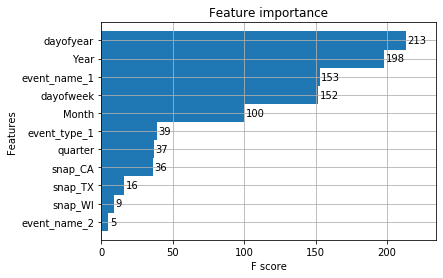

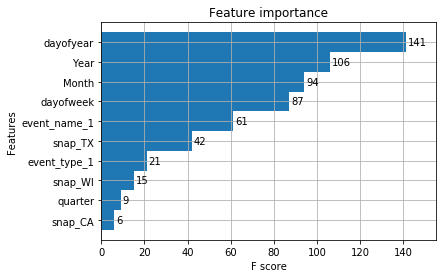

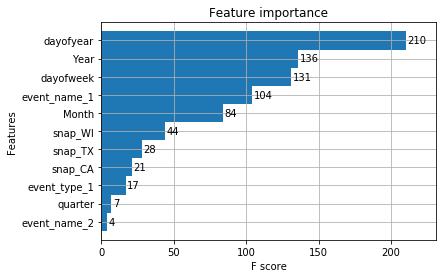

In [6]:
for i in series.index:

    print('=' * 100)
    print(i)
    
    df_series = create_features(series.loc[i,:], dates)

    pred_y = train(df_series)

    n_days = 28
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_series.index[-n_days:], 
        y=df_series.iloc[-n_days:, 0], 
        name="y_true", 
        line_color='gray'))
    fig.add_trace(go.Scatter(
        x=df_series.index[-n_days:], 
        y=pred_y.PREDICTION[-n_days:], 
        name="y_pred", 
        line_color='red'))
    fig.show()

In [6]:
global cv_results
cv_results = None

def train_grid_search(df_product, params=None):
    error = list()
    y = df_product.iloc[:,0]
    split_date = df_product.index[-60]
    df_train = df_product.loc[df_product.index < split_date].copy()
    df_valid = df_product.loc[df_product.index >= split_date].copy()
    X_train, y_train = features_(df_train, 
                                 train=True, 
                                 label=df_product.columns[0])
    X_valid, y_valid = features_(df_valid, 
                               train=False, 
                               label=df_product.columns[0])

    model = GridSearchCV(estimator=xgb.XGBRegressor(),
                         param_grid=params,
                         cv = 10,
                         n_jobs=-1,
                         verbose=False)

    model.fit(X_train, 
              y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              early_stopping_rounds=10,
              verbose=False)
    global cv_results 
    cv_results = pd.DataFrame(model.cv_results_)
    print(model.best_params_)
    print(model.best_score_)

    model = xgb.XGBRegressor(**model.best_params_)
    model.fit(X_train, 
              y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              early_stopping_rounds=10,
              verbose=True)

    _ = plot_importance(model, height=1)
    
    df_valid['PREDICTION'] = model.predict(X_valid)

    # train_error = eval_func(y_train, model.predict(X_train))
    train_error = math.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    print('-' * 100)
    print('Train Error: %.4f RMSE' % (train_error))

    # valid_error = eval_func(y_valid, df_valid['PREDICTION'])
    valid_error =  math.sqrt(mean_squared_error(y_valid, df_valid['PREDICTION']))
    print('Valid Error: %.4f RMSE' % (valid_error))
    print('-' * 100)

    df_final = pd.concat([df_train, df_valid], sort = False)
        
    return df_final

CA
[14:34:36] WARNING: /Users/luxuzheng/Downloads/xgboost/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
0.6944726488813631
[14:34:37] WARNING: /Users/luxuzheng/Downloads/xgboost/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:13740.6	validation_1-rmse:16598.9
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:12394.7	validation_1-rmse:15188.5
[2]	validation_0-rmse:11184.3	validation_1-rmse:13904.8
[3]	validation_0-rmse:10096.4	validation_1-rmse:12741.4
[4]	validation_0-rmse:9118.36	validation_1-rmse:11714.2
[5]	validation_0-rmse:8239.84	validation_1-rmse:10774.9
[6]	validation_0-rmse:7449.12	validation_1-rmse:9897.44
[7]	validation_0-rmse:6739.2	validation_1-rmse:9126.3
[8]	validat

TX
[14:36:41] WARNING: /Users/luxuzheng/Downloads/xgboost/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
0.6681254619528756
[14:36:41] WARNING: /Users/luxuzheng/Downloads/xgboost/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:9044.82	validation_1-rmse:10241.4
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:8158.59	validation_1-rmse:9322.14
[2]	validation_0-rmse:7361.78	validation_1-rmse:8480.97
[3]	validation_0-rmse:6645.71	validation_1-rmse:7728.55
[4]	validation_0-rmse:6002.24	validation_1-rmse:7037.22
[5]	validation_0-rmse:5424.04	validation_1-rmse:6433.31
[6]	validation_0-rmse:4904.85	validation_1-rmse:5867.87
[7]	validation_0-rmse:4439.04	validation_1-rmse:5359.03
[8]	valid

WI
[14:40:03] WARNING: /Users/luxuzheng/Downloads/xgboost/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500}
0.6651155765456153
[14:40:03] WARNING: /Users/luxuzheng/Downloads/xgboost/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:9205.69	validation_1-rmse:12798.9
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:8758.07	validation_1-rmse:12291.5
[2]	validation_0-rmse:8333.01	validation_1-rmse:11809.6
[3]	validation_0-rmse:7929.39	validation_1-rmse:11356.4
[4]	validation_0-rmse:7546.05	validation_1-rmse:10913.4
[5]	validation_0-rmse:7182.34	validation_1-rmse:10489.3
[6]	validation_0-rmse:6836.44	validation_1-rmse:10101.1
[7]	validation_0-rmse:6507.96	validation_1-rmse:9724.25
[8]	vali

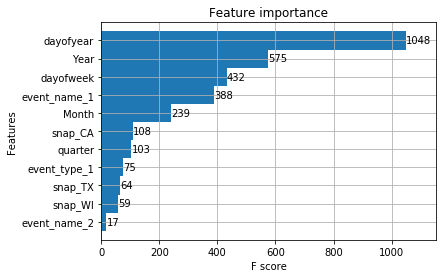

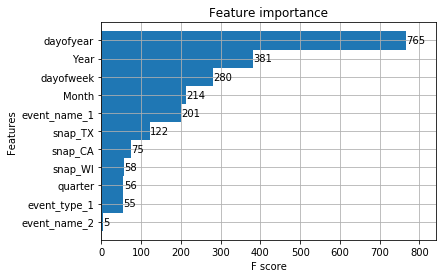

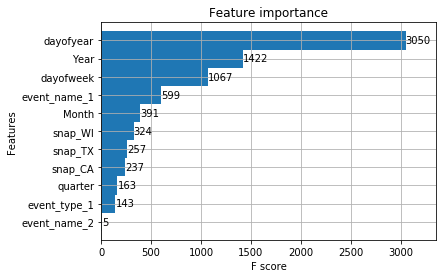

In [7]:
results = []

params = {
    "learning_rate" : [0.001, 0.01, 0.05, 0.1, 0.5],
    "max_depth" : [5, 10, 15, 20],
    "n_estimators": [100, 200, 500, 1000, 2000]
    }

for i in series.index:
    
    print('=' * 100)
    print(i)

    df_series = create_features(series.loc[i,:], dates)

    pred_y = train_grid_search(df_series, params=params)

    n_days = 28

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_series.index[-n_days:], 
        y=df_series.iloc[-n_days:, 0], 
        name="y_true", 
        line_color='gray'))
    fig.add_trace(go.Scatter(
        x=df_series.index[-n_days:], 
        y=pred_y.PREDICTION[-n_days:], 
        name="y_pred", 
        line_color='red'))
    fig.show()

In [8]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.562354,0.027817,0.007485,0.004211,0.001,5,100,"{'learning_rate': 0.001, 'max_depth': 5, 'n_es...",-20.697634,-19.657630,...,-15.196556,-20.851302,-18.267604,-25.095547,-17.371941,-27.892271,-19.964816,-20.334883,3.523532,97
1,1.049520,0.033308,0.009626,0.004475,0.001,5,200,"{'learning_rate': 0.001, 'max_depth': 5, 'n_es...",-16.729154,-16.119320,...,-12.349918,-16.771483,-14.725091,-20.385356,-14.039261,-22.873133,-16.748410,-16.498431,2.959181,93
2,2.228246,0.042328,0.014408,0.003406,0.001,5,500,"{'learning_rate': 0.001, 'max_depth': 5, 'n_es...",-8.815502,-8.992463,...,-6.603261,-8.704923,-7.685877,-10.914514,-7.302235,-12.184384,-10.039169,-8.781729,1.753988,92
3,4.501695,0.128218,0.025482,0.005638,0.001,5,1000,"{'learning_rate': 0.001, 'max_depth': 5, 'n_es...",-2.701303,-3.148985,...,-2.237213,-2.622536,-2.261491,-3.619629,-2.146562,-4.011531,-4.300916,-2.857039,0.848197,88
4,9.291883,0.088753,0.057319,0.009817,0.001,5,2000,"{'learning_rate': 0.001, 'max_depth': 5, 'n_es...",0.198057,-0.027155,...,0.082929,0.270190,0.327518,0.093417,0.392186,0.132555,-0.710886,0.114349,0.304926,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.794337,0.149729,0.008938,0.003862,0.5,20,100,"{'learning_rate': 0.5, 'max_depth': 20, 'n_est...",0.295771,0.212343,...,0.571368,0.754727,0.740595,0.782773,0.750376,0.601196,0.477755,0.558903,0.195087,63
96,0.781633,0.197666,0.007890,0.003152,0.5,20,200,"{'learning_rate': 0.5, 'max_depth': 20, 'n_est...",0.295771,0.212343,...,0.571368,0.754727,0.740595,0.782773,0.750376,0.601196,0.477755,0.558903,0.195087,63
97,0.939383,0.416931,0.007783,0.002238,0.5,20,500,"{'learning_rate': 0.5, 'max_depth': 20, 'n_est...",0.295771,0.212343,...,0.571368,0.754727,0.740595,0.782773,0.750376,0.601196,0.477755,0.558903,0.195087,63
98,0.976260,0.595263,0.006616,0.002086,0.5,20,1000,"{'learning_rate': 0.5, 'max_depth': 20, 'n_est...",0.295771,0.212343,...,0.571368,0.754727,0.740595,0.782773,0.750376,0.601196,0.477755,0.558903,0.195087,63


In [10]:
cv_results.to_csv('cv_results.csv')